# Prototype FAIMG - Implementation of Hansch method

Be sure to check the readme before running this exemple. If you encounter any errors, it should be documented in the readme

## Imports

In [1]:
import faimg as fg
import time
import numpy as np
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

## Loading images

Images available in the sample folder are UAE satellite image segmented by Humans in the Loop : 
https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

In [2]:
# Some utils to serialize images
class_mapping = {
    (0x3C, 0x10, 0x98): 1,  # Building
    (0x84, 0x29, 0xF6): 2,  # Land (unpaved area)
    (0x6E, 0xC1, 0xE4): 3,  # Road
    (0xFE, 0xDD, 0x3A): 4,  # Vegetation
    (0xE2, 0xA9, 0x29): 5,  # Water
    (0x9B, 0x9B, 0x9B): 6,  # Unlabeled
}


def labels_to_rgb(labels):
    # Reverse the class mapping dictionary to get RGB values as keys
    rgb_mapping = {label: rgb for rgb, label in class_mapping.items()}

    # Initialize an empty array to store the RGB image
    image = np.empty((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

    # Iterate over each pixel in the labels array
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            # Get the label of the current pixel
            label = labels[i, j]

            # Map the label to an RGB value using the reversed mapping
            rgb = rgb_mapping.get(
                label, (0, 0, 0)
            )  # Default to black if no mapping exists

            # Assign the RGB value to the corresponding pixel in the image array
            image[i, j] = rgb

    return image

def loadDataAndLabel(imgDataPath, labelDataPath):
    imData = Image.open(imgDataPath)
    imLabel = Image.open(labelDataPath)

    X = np.array(imData)
    yRaw = np.array(imLabel)


    def rgb_to_labels(image):
        is_rgb = len(image.shape) == 3
        # Initialize an empty array to store the labels
        labels = np.empty(image.shape[:2], dtype=np.uint8)

        # Iterate over each pixel in the image
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # Get the RGB value of the current pixel

                # Assign the label to the corresponding pixel in the labels array
                if is_rgb:                    
                    rgb = tuple(image[i, j])

                    # Map the RGB value to a class label using the provided mapping
                    label = class_mapping.get(
                        rgb, 6
                    )  # Default to class 6 - Unlabeled if no mapping exists
                    labels[i, j] = label
                else:
                    labels[i, j] = image[i, j]


                

        return labels

    y = rgb_to_labels(yRaw)

    return X, y

In [3]:
# Loading image data
X_full, y_full = loadDataAndLabel("samples/image_data.jpg", "samples/image_label.png")

FileNotFoundError: [Errno 2] No such file or directory: 'samples/image_data_2.jpg'

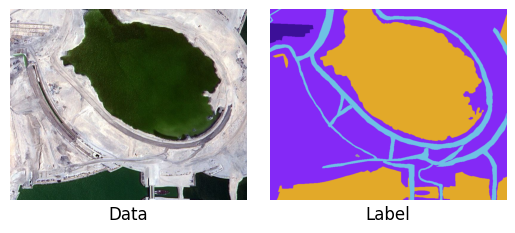

In [ ]:
# Plot images

y_full_rbg = labels_to_rgb(y_full)


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the first image in the first subplot
axs[0].imshow(X_full)
axs[0].axis('off')  # Optional: Turn off axis ticks and labels
axs[0].text(0.5, -0.1, 'Data', transform=axs[0].transAxes,
            fontsize=12, ha='center')

# Plot the second image in the second subplot
axs[1].imshow(y_full_rbg)
axs[1].axis('off')  # Optional: Turn off axis ticks and labels
axs[1].text(0.5, -0.1, 'Label', transform=axs[1].transAxes,
            fontsize=12, ha='center')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the figure
plt.show()

We will focus on a subset of the images, to get faster results

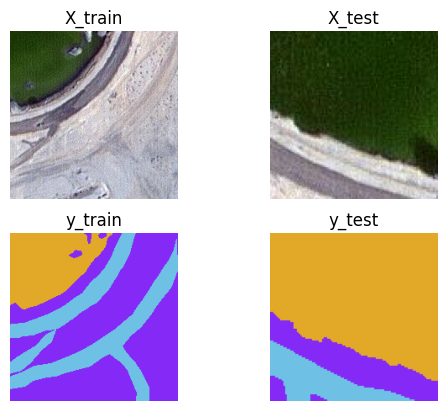

In [ ]:
X_train, X_test, y_train, y_test = X_full[-300:-100, -200:], X_full[-300:-200, -400:-300], y_full[-300:-100, -200:], y_full[-300:-200, -400:-300]

y_train_rbg = labels_to_rgb(y_train)
y_train_rbg_image = Image.fromarray(y_train_rbg)

y_test_rbg = labels_to_rgb(y_test)
y_test_rbg_image = Image.fromarray(y_test_rbg)

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Plot the X_train image in the top-left subplot
axs[0, 0].imshow(X_train)
axs[0, 0].axis('off')  # Optional: Turn off axis ticks and labels
axs[0, 0].set_title('X_train')

# Plot the X_test image in the top-right subplot
axs[0, 1].imshow(X_test)
axs[0, 1].axis('off')  # Optional: Turn off axis ticks and labels
axs[0, 1].set_title('X_test')

# Plot the y_train image in the bottom-left subplot
axs[1, 0].imshow(y_train_rbg_image)
axs[1, 0].axis('off')  # Optional: Turn off axis ticks and labels
axs[1, 0].set_title('y_train')

# Plot the y_test image in the bottom-right subplot
axs[1, 1].imshow(y_test_rbg_image)
axs[1, 1].axis('off')  # Optional: Turn off axis ticks and labels
axs[1, 1].set_title('y_test')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Show the figure
plt.show()

## Extract patches

In [ ]:
patchSize = 9
regionSize = 3
# small image so little stride
stride = 3

In [ ]:
imProc = fg.ImageProcessor(X_train)

# patches with stride for prediction
patches_train_no_stride = imProc.extract_all_patches_np(patchSize, regionSize, 1)
# patches with stride for training
patches_train = imProc.extract_all_patches_np(patchSize, regionSize, stride)

# Since we consider only central pixels of patches, we are cropping the image. So we have to crop it for the y as well !

lower_bound = patchSize // 2

x_upper_bound = y_train.shape[0] - patchSize // 2
y_upper_bound = y_train.shape[1] - patchSize // 2

if patchSize % 2 == 0:
    x_upper_bound += 1
    y_upper_bound += 1

# y_train_base_with_patch to compare for prediction score
y_train_base_with_patch = y_train[
    lower_bound:x_upper_bound,
    lower_bound:y_upper_bound,
]


# y_train_strided to train the model
y_train_strided = y_train[::stride,::stride]

x_upper_bound = y_train_strided.shape[0] - patchSize // 2
y_upper_bound = y_train_strided.shape[1] - patchSize // 2

if patchSize % 2 == 0:
    x_upper_bound += 1
    y_upper_bound += 1

y_train_strided = y_train_strided[
    lower_bound:x_upper_bound,
    lower_bound:y_upper_bound,
].flatten()



imProc = fg.ImageProcessor(X_test)

# patches with stride for prediction
patches_test_no_stride = imProc.extract_all_patches_np(patchSize, regionSize, 1)

x_upper_bound = y_test.shape[0] - patchSize // 2
y_upper_bound = y_test.shape[1] - patchSize // 2

if patchSize % 2 == 0:
    x_upper_bound += 1
    y_upper_bound += 1

# y_test_base_with_patch to compare for prediction score
y_test_base_with_patch = y_test[
    lower_bound:x_upper_bound,
    lower_bound:y_upper_bound,
]

assert patches_train.shape == y_train_strided.shape

## Hansch Forest

In [ ]:
forest = fg.HanschForest(
    featureGenerated=20, patchSize=patchSize, regionSize=regionSize, nbTrees=16, maxDepth=None, minSampleSize=1
)

In [ ]:

start = time.time()
forest.fit(patches_train, y_train_strided)
end = time.time()
print("Forest created in : ", end - start, "secs !")

8/16 tree created
16/16 tree created
forest created !
Forest created in :  120.98271083831787 secs !


## Making prediction on train set

In [ ]:
start = time.time()
prediction_train = forest.predict(patches_train_no_stride)
end = time.time()

print("Got prediction in : ", end - start, "secs !")

Got prediction in :  65.09054064750671 secs !


Accuracy train :  0.6848958333333334
f1 train :  0.6505016046712497


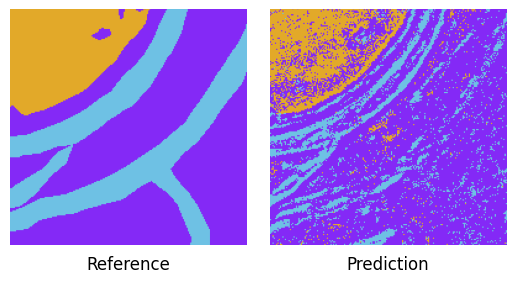

In [ ]:
print("Accuracy train : ", accuracy_score(y_train_base_with_patch.flatten(), prediction_train))
print("f1 train : ", f1_score(y_train_base_with_patch.flatten(), prediction_train, average="macro"))


rgb_image = labels_to_rgb(y_train_base_with_patch)
train_true = Image.fromarray(rgb_image)

prediction_test_reshaped = prediction_train.reshape(y_train_base_with_patch.shape)
rgb_image = labels_to_rgb(prediction_test_reshaped)
train_predict = Image.fromarray(rgb_image)


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the first image in the first subplot
axs[0].imshow(train_true)
axs[0].axis('off')  # Optional: Turn off axis ticks and labels
axs[0].text(0.5, -0.1, 'Reference', transform=axs[0].transAxes,
            fontsize=12, ha='center')

# Plot the second image in the second subplot
axs[1].imshow(train_predict)
axs[1].axis('off')  # Optional: Turn off axis ticks and labels
axs[1].text(0.5, -0.1, 'Prediction', transform=axs[1].transAxes,
            fontsize=12, ha='center')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the figure
plt.show()

## Making prediction on test set

In [ ]:
start = time.time()
prediction_test = forest.predict(patches_test_no_stride)
end = time.time()

print("Got prediction in : ", end - start, "secs !")

Got prediction in :  12.827577829360962 secs !


Accuracy train :  0.7959593572778828
f1 train :  0.668484684110702


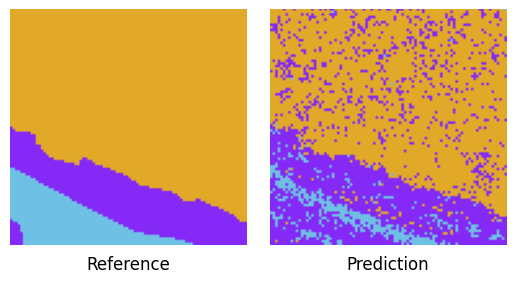

In [ ]:
print("Accuracy train : ", accuracy_score(y_test_base_with_patch.flatten(), prediction_test))
print("f1 train : ", f1_score(y_test_base_with_patch.flatten(), prediction_test, average="macro"))

rgb_image = labels_to_rgb(y_test_base_with_patch)
test_true = Image.fromarray(rgb_image)

prediction_test_reshaped = prediction_test.reshape(y_test_base_with_patch.shape)
rgb_image = labels_to_rgb(prediction_test_reshaped)
test_predict = Image.fromarray(rgb_image)


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot the first image in the first subplot
axs[0].imshow(test_true)
axs[0].axis('off')  # Optional: Turn off axis ticks and labels
axs[0].text(0.5, -0.1, 'Reference', transform=axs[0].transAxes,
            fontsize=12, ha='center')

# Plot the second image in the second subplot
axs[1].imshow(test_predict)
axs[1].axis('off')  # Optional: Turn off axis ticks and labels
axs[1].text(0.5, -0.1, 'Prediction', transform=axs[1].transAxes,
            fontsize=12, ha='center')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Show the figure
plt.show()